
# Employee Attrition Prediction — Project Notebook

This notebook contains an **intermediate end-to-end pipeline** for the Employee Attrition prediction project.
It includes:
- Problem definition
- Data loading
- Data understanding & cleaning
- Preprocessing (encoding, scaling, SMOTE)
- EDA (visualizations)
- Model training (RandomForest)
- Prediction example
- Saving the final model & scaler

**Notes:** Place `employee_attrition_dataset.csv` in the same working directory before running.


In [ ]:

# 0. Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
random_state = 42
print('Libraries loaded.')

Libraries loaded.


In [3]:

# 1. Load dataset
df = pd.read_csv("employee_attrition_dataset.csv")
print("Shape:", df.shape)
df.head()


Shape: (1000, 26)


,Employee_ID,Age,Gender,Marital_Status,Department,Job_Role,Job_Level,Monthly_Income,Hourly_Rate,Years_at_Company,...,Overtime,Project_Count,Average_Hours_Worked_Per_Week,Absenteeism,Work_Environment_Satisfaction,Relationship_with_Manager,Job_Involvement,Distance_From_Home,Number_of_Companies_Worked,Attrition
0,1,58,Female,Married,IT,Manager,1,15488,28,15,...,No,6,54,17,4,4,4,20,3,No
1,2,48,Female,Married,Sales,Assistant,5,13079,28,6,...,Yes,2,45,1,4,1,2,25,2,No
2,3,34,Male,Married,Marketing,Assistant,1,13744,24,24,...,Yes,6,34,2,3,4,4,45,3,No
3,4,27,Female,Divorced,Marketing,Manager,1,6809,26,10,...,No,9,48,18,2,3,1,35,3,No
4,5,40,Male,Divorced,Marketing,Executive,1,10206,52,29,...,No,3,33,0,4,1,3,44,3,No


# New Section

In [ ]:

# 2. Data understanding
print(df.info())
print(df.describe().T)
print('\nAttrition distribution:\n', df['Attrition'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Employee_ID                    1000 non-null   int64 
 1   Age                            1000 non-null   int64 
 2   Gender                         1000 non-null   object
 3   Marital_Status                 1000 non-null   object
 4   Department                     1000 non-null   object
 5   Job_Role                       1000 non-null   object
 6   Job_Level                      1000 non-null   int64 
 7   Monthly_Income                 1000 non-null   int64 
 8   Hourly_Rate                    1000 non-null   int64 
 9   Years_at_Company               1000 non-null   int64 
 10  Years_in_Current_Role          1000 non-null   int64 
 11  Years_Since_Last_Promotion     1000 non-null   int64 
 12  Work_Life_Balance              1000 non-null   int64 
 13  Job_

In [ ]:

# 3. Data cleaning
# Drop Employee_ID if present
if 'Employee_ID' in df.columns:
    df = df.drop(columns=['Employee_ID'])
print('Columns now:', df.columns.tolist())


Columns now: ['Age', 'Gender', 'Marital_Status', 'Department', 'Job_Role', 'Job_Level', 'Monthly_Income', 'Hourly_Rate', 'Years_at_Company', 'Years_in_Current_Role', 'Years_Since_Last_Promotion', 'Work_Life_Balance', 'Job_Satisfaction', 'Performance_Rating', 'Training_Hours_Last_Year', 'Overtime', 'Project_Count', 'Average_Hours_Worked_Per_Week', 'Absenteeism', 'Work_Environment_Satisfaction', 'Relationship_with_Manager', 'Job_Involvement', 'Distance_From_Home', 'Number_of_Companies_Worked', 'Attrition']


In [ ]:

# 4. Preprocessing
# Encode target
df['Attrition'] = df['Attrition'].map({'Yes':1, 'No':0})

# Identify categorical and numerical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Attrition')

print('Categorical:', cat_cols)
print('Numerical:', num_cols)

# One-hot encode categorical vars
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print('Encoded shape:', df_encoded.shape)


Categorical: ['Gender', 'Marital_Status', 'Department', 'Job_Role', 'Overtime']
Numerical: ['Age', 'Job_Level', 'Monthly_Income', 'Hourly_Rate', 'Years_at_Company', 'Years_in_Current_Role', 'Years_Since_Last_Promotion', 'Work_Life_Balance', 'Job_Satisfaction', 'Performance_Rating', 'Training_Hours_Last_Year', 'Project_Count', 'Average_Hours_Worked_Per_Week', 'Absenteeism', 'Work_Environment_Satisfaction', 'Relationship_with_Manager', 'Job_Involvement', 'Distance_From_Home', 'Number_of_Companies_Worked']
Encoded shape: (1000, 31)


In [ ]:

# 5. Split, scale, and balance
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# Scale numeric columns (only original numeric columns)
numeric_cols_to_scale = [c for c in num_cols if c in X_train.columns]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numeric_cols_to_scale] = scaler.fit_transform(X_train[numeric_cols_to_scale])
X_test[numeric_cols_to_scale] = scaler.transform(X_test[numeric_cols_to_scale])
print('Scaling done.')

# SMOTE on training data
sm = SMOTE(random_state=random_state)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print('Resampled train shape:', X_train_res.shape)
print('Resampled class distribution:\n', y_train_res.value_counts())


Train shape: (800, 30) Test shape: (200, 30)
Scaling done.
Resampled train shape: (1298, 30)
Resampled class distribution:
 Attrition
0    649
1    649
Name: count, dtype: int64


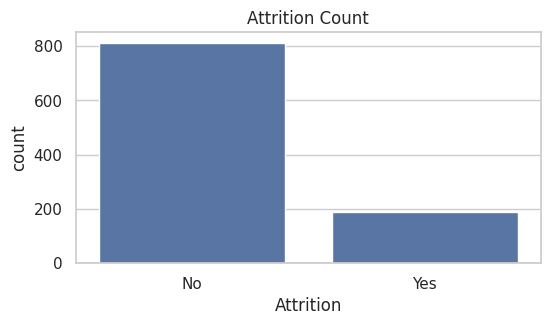

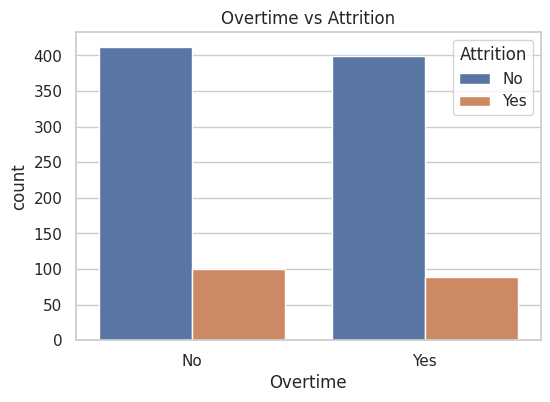

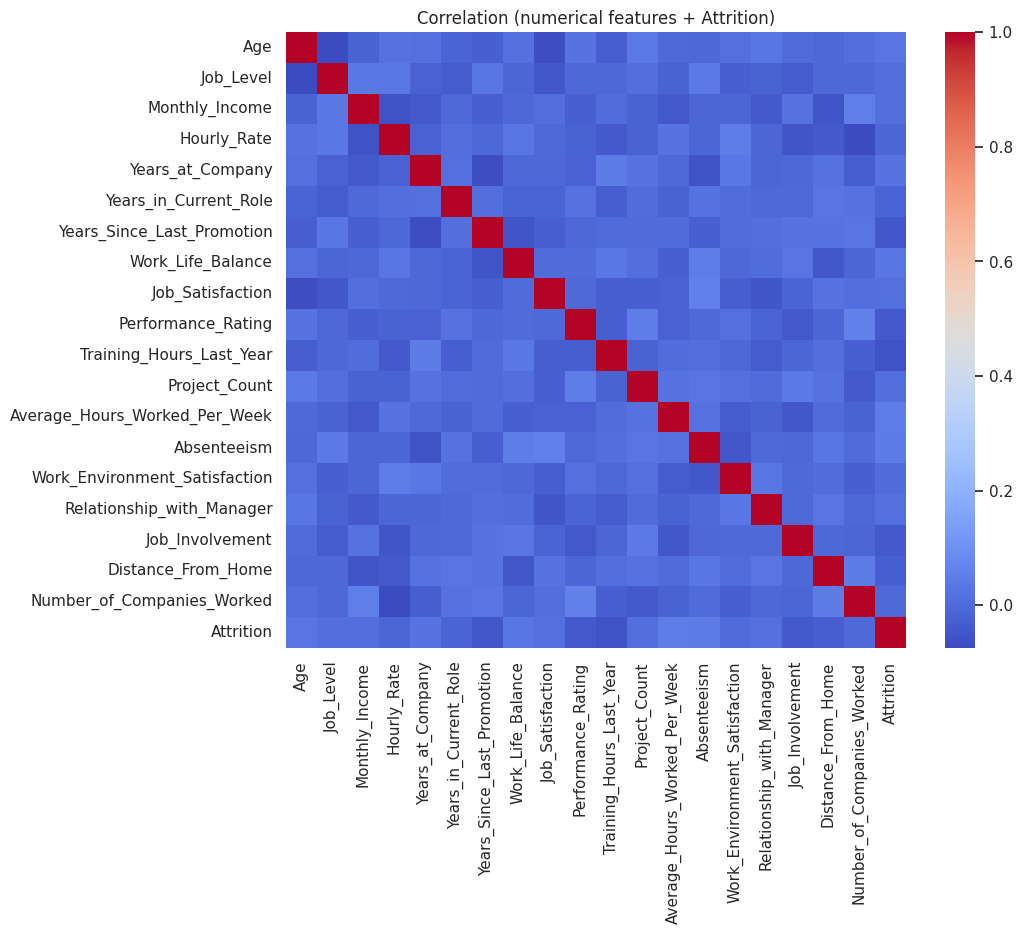

In [ ]:

# 6. EDA (quick visuals)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,3))
sns.countplot(x=df['Attrition'].map({1:'Yes',0:'No'}))
plt.title('Attrition Count')
plt.show()

# Overtime vs Attrition (if available)
if 'Overtime' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df['Overtime'], hue=df['Attrition'].map({1:'Yes',0:'No'}))
    plt.title('Overtime vs Attrition')
    plt.show()

# Correlation heatmap (numerical)
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ['Attrition']].corr(), cmap='coolwarm')
plt.title('Correlation (numerical features + Attrition)')
plt.show()


In [ ]:
# 7-8. Model training (Single model: RandomForest)
# =========================
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForest
random_state = 42
rfc = RandomForestClassifier(random_state=random_state, n_jobs=-1)

# Train on SMOTE-resampled training data
rfc.fit(X_train_res, y_train_res)
print("RandomForest trained.")



RandomForest trained.


Test Accuracy: 0.7800
Confusion Matrix:
[[155   7]
 [ 37   1]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8073    0.9568    0.8757       162
           1     0.1250    0.0263    0.0435        38

    accuracy                         0.7800       200
   macro avg     0.4661    0.4916    0.4596       200
weighted avg     0.6777    0.7800    0.7176       200

ROC-AUC: 0.4960


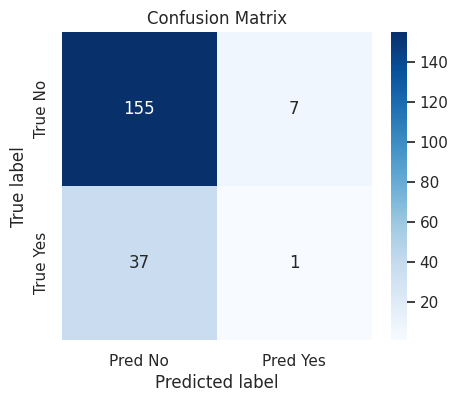

In [ ]:

# 9. Model Evaluation (Accuracy + Confusion Matrix)
# =========================
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on test set
y_test_pred = rfc.predict(X_test)
y_test_proba = rfc.predict_proba(X_test)[:,1]

# Accuracy
acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# small classification report for more context
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

#  ROC-AUC for extra info
from sklearn.metrics import roc_auc_score
try:
    auc = roc_auc_score(y_test, y_test_proba)
    print(f"ROC-AUC: {auc:.4f}")
except:
    pass

# Plot confusion matrix (visual)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred No','Pred Yes'], yticklabels=['True No','True Yes'])
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [ ]:
# 10. Prediction examples & save model
# =========================
import joblib

# Save model and scaler
joblib.dump(rfc, 'best_random_forest_attrition.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Saved model and scaler.')

# Predict on test set (show first 10 predictions)
results = X_test.copy()
results['true_attrition'] = y_test.values
results['pred_attrition'] = y_test_pred
results['pred_prob'] = y_test_proba
results[['true_attrition','pred_attrition','pred_prob']].head(10)


Saved model and scaler.


,true_attrition,pred_attrition,pred_prob
852,0,0,0.30
942,0,0,0.38
476,0,0,0.29
424,0,0,0.29
691,0,0,0.20
485,0,1,0.56
289,1,0,0.18
279,0,0,0.24
199,0,0,0.18
293,0,0,0.31


In [ ]:
# Save metadata needed by the Streamlit app
import joblib

# X is the training feature DataFrame used earlier.
feature_names = X.columns.tolist()            # full list of features used to train the model
numeric_cols_to_scale = numeric_cols_to_scale # list you computed earlier in the notebook

joblib.dump(feature_names, "feature_names.pkl")
joblib.dump(numeric_cols_to_scale, "numeric_cols_to_scale.pkl")
print("Saved feature_names.pkl and numeric_cols_to_scale.pkl")


Saved feature_names.pkl and numeric_cols_to_scale.pkl


In [ ]:
# Example: Predict for a single new employee (using first row of original df)
sample = df.drop(columns=['Attrition']).iloc[0:1]  # original pre-encoding df
# encode sample same as training df (get_dummies + align)
sample_encoded = pd.get_dummies(sample, columns=cat_cols, drop_first=True)
sample_encoded = sample_encoded.reindex(columns=X.columns, fill_value=0)
# scale numeric features
sample_encoded[numeric_cols_to_scale] = scaler.transform(sample_encoded[numeric_cols_to_scale])
# make prediction
single_pred = rfc.predict(sample_encoded)[0]
single_proba = rfc.predict_proba(sample_encoded)[0,1]
print(f"Single-sample prediction: Attrition={single_pred} (probability={single_proba:.3f})")


Single-sample prediction: Attrition=0 (probability=0.090)
